## Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importing the csv file

In [2]:
df = pd.read_csv("/content/data1.csv")
df.head()

,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [3]:
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index("date", inplace=True)
df=df.asfreq('b')
df=df.fillna(method='ffill')
df.reset_index(inplace=True)
df.drop(columns='date',inplace=True)
df.head()

,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


# Xgboost Function

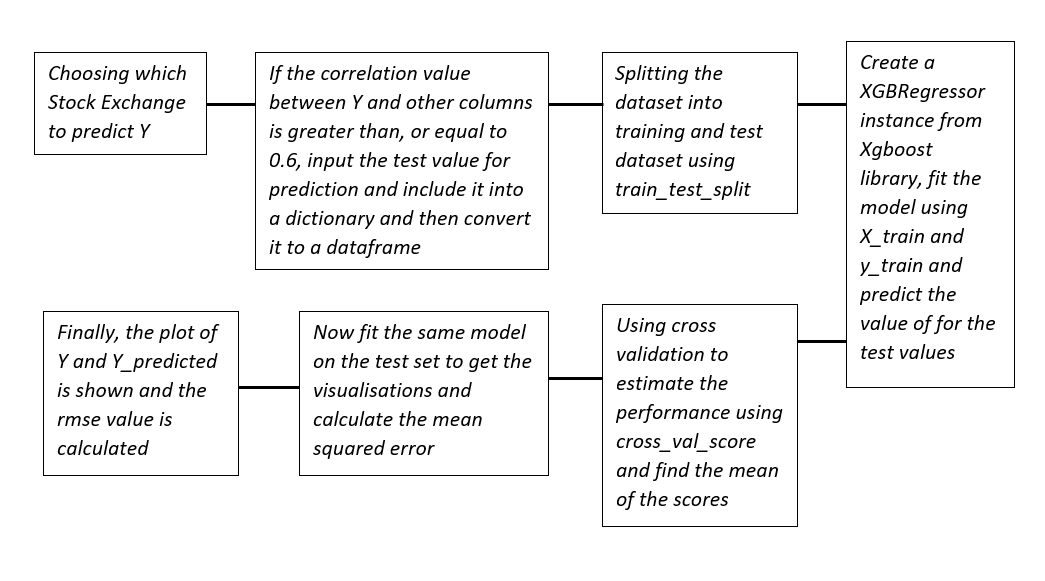

In [4]:
def predict_function():
  str1 = str(input('Which stock exchange do you want to predict: '))
  print('---------------------------------------------------------------')
  if str1 == 'NIKKEI':
    print('There is no good correlation among columns and NIKKEI so cannot be predicted')
    return
  y = df[str1]
  dict1 = {}
  value = 0
  lst = []
  for i in df.columns:
    if i!=str1:
      j = y.corr(df[i])
      if j>=0.6:
        lst.append(i)
        value = float(input('Enter the test value for column {}:   '.format(i)))
        dict1[i]=value
  test_values = pd.DataFrame(dict1,index=[0])
  X = df[lst]
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  my_model = XGBRegressor(n_estimators=1000, early_stopping_rounds=5,verbosity=0)
  my_model.fit(X_train, y_train,verbose=False)
  print('----------------------------------------------------------------')
  scores = -1 * cross_val_score(my_model, X_test, y_test,
                              cv=5,
                              scoring='neg_mean_absolute_error')

  print("Mean absolute error scores for cross validation:\n", scores)
  print('---------------------------------------------------------------')
  print("Average mean absolute error score (across experiments):",scores.mean())
  pred_test_values = my_model.predict(test_values)
  print('---------------------------------------------------------------')
  print('The predicted stock exchange value is: ',pred_test_values)
  print('---------------------------------------------------------------')
  predictions = my_model.predict(X_test)
  predictions = pd.DataFrame(predictions)
  predictions.columns = ['predictions']
  y_test = y_test.to_frame(name=str1).reset_index()
  y_test.drop(columns='index',inplace=True)
  test_pred = pd.concat([y_test,predictions],axis=1,ignore_index=True)
  test_pred.columns = [str1,str1+'_predicted']
  mse = math.sqrt(mean_squared_error(test_pred[str1],test_pred[str1+'_predicted']))
  print('Root mean square error between the predictions and the test values are', mse)
  print('---------------------------------------------------------------')
  test_pred.plot(figsize=(16,9))

Which stock exchange do you want to predict: ISE
---------------------------------------------------------------
Enter the test value for column ISE.1:   0.038376	
Enter the test value for column DAX:   0.002193
Enter the test value for column FTSE:   0.003894	
Enter the test value for column EU:   0.012698
Enter the test value for column EM:   0.028524
----------------------------------------------------------------
Mean absolute error scores for cross validation:
 [0.00425394 0.00456587 0.00475533 0.00392497 0.00468747]
---------------------------------------------------------------
Average mean absolute error score (across experiments): 0.004437516757469941
---------------------------------------------------------------
The predicted stock exchange value is:  [0.03489619]
---------------------------------------------------------------
Root mean square error between the predictions and the test values are 0.005299169059987376
----------------------------------------------------------

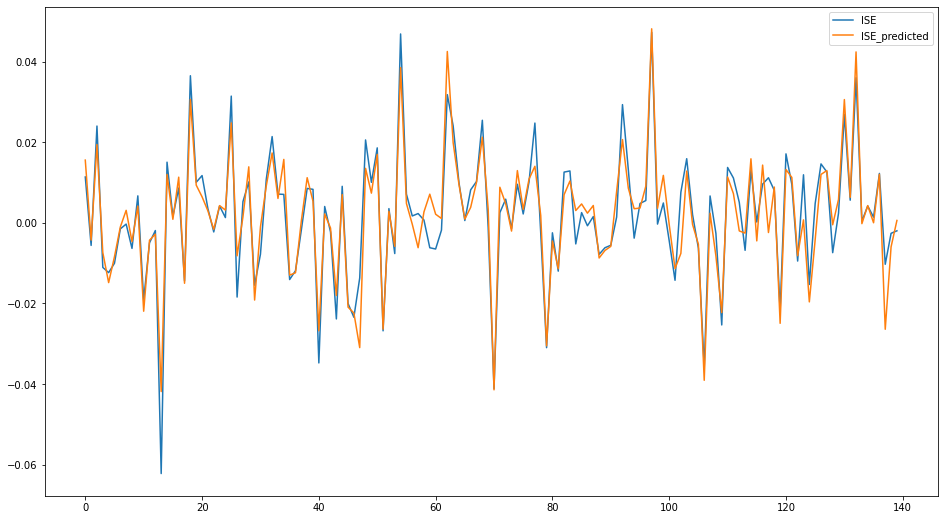

In [5]:

predict_function()